In [1]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

# Table of content
1. Define functions, load data
    - Import `interactive` maps module
    - Define functions for calculating `distance` on Earth
    - Load DataFrames for `apartaments` and `metro` 
2. Prepare data
    - Add `price` to `rental price` in order to get `real price`
    - Find `distance` to nearest metro station for all valid houses
    - Find `distance` to city center (`PKiN`) for all valid houses
    - Read `districts'` shape data
    - Assign `districts` to all houses 
3. Analyse dataset
    - Price `violinplots` for each district
    - Show median price for each district (**interactive map**) 
    - Correlate `data` (**with strong interpreations**)
    - Distribution of apartment's floor level
4. Prediction
    - Linear regressor and `support vector mashines`
    - Analyse of `error` in regression approach
    - Test on some hand-typed data 

# 1. Define functions, load data

## 1.1. Import interactive maps module

In [2]:
import geopandas as gpd
import folium
from folium import Choropleth, Circle, Marker
from folium.plugins import HeatMap, MarkerCluster

In [3]:
# Function for displaying the map

def embed_map(m, file_name):
    from IPython.display import IFrame
    m.save(file_name)
    return IFrame(file_name, width='100%', height='500px')

## 1.2. Define functions for calculating distance on Earth

In [4]:
# Using geopy
import geopy.distance

def dist(a, b):
    return geopy.distance.geodesic((a.x, a.y), (b.x, b.y)).km

In [5]:
# Using geopandas
def dist_2(a, b):
    a = gpd.GeoSeries(Point(a.y, a.x), crs=({"init":"epsg:4326"})).to_crs(epsg=3310)
    b = gpd.GeoSeries(Point(b.y, b.x), crs=({"init":"epsg:4326"})).to_crs(epsg=3310)
    return a.distance(b) / 1000

## 1.3. Load DataFrames for `apartaments` and `metro`

In [6]:
apartaments = pd.read_csv("apartaments.csv")
metro = pd.read_csv("metro.csv")

# 2. Prepare data

## 2.1. Add `price` to `rental price` in order to get `real price`

In [7]:
# Function to check if value is Nan or not
def notNan(a):
    return a == a

In [8]:
def real_price(row):
    if notNan(row['Czynsz - dodatkowo']):
        return int(row['Cena']) + int(row['Czynsz - dodatkowo'])
    else:
        return int(row['Cena'])

In [9]:
if 'Cena rzeczywista' in apartaments or not 'Cena' in apartaments:
    print("Reloading apartamens.csv file")
    apartaments = pd.read_csv("apartaments.csv")
    
apartaments.insert(1, "Cena rzeczywista", apartaments.apply(real_price, axis=1))
#apartaments = apartaments.drop(columns = ['Cena', 'Czynsz - dodatkowo'])

## 2.2. Find distance to nearest metro station for all valid houses

In [10]:
nearest_metro_dist = []
nearest_metro_name = []

for idx, house in apartaments.iterrows():
    if notNan(house['φ']):
        list_ = [dist(Point(house['φ'], house['λ']), Point(station['φ'], station['λ']))
                 for jdx, station in metro.iterrows()]
        nearest_metro_dist.append(round(min(list_), 4))
        nearest_metro_name.append(metro.iloc[np.argmin(list_)]['Nazwa'])
    else:
        nearest_metro_dist.append(np.nan)
        nearest_metro_name.append(np.nan)
        
        
if "Odległość od najbliższej stacji metra" in apartaments:
    apartaments = apartaments.drop('Odległość od najbliższej stacji metra', axis=1)
apartaments.insert(apartaments.shape[1], "Odległość od najbliższej stacji metra", nearest_metro_dist)

if "Najbliższa stacja metra" in apartaments:
    apartaments = apartaments.drop('Najbliższa stacja metra', axis=1)
apartaments.insert(apartaments.shape[1], "Najbliższa stacja metra", nearest_metro_name)

## 2.3. Find distance to city center (`PKiN`) for all valid houses

In [11]:
city_center_dist = []

for idx, house in apartaments.iterrows():
    if notNan(house['φ']):
        city_center_dist.append(round(dist(Point(house['φ'], house['λ']), Point(52.2323, 21.0000)), 4))
    else:
        city_center_dist.append(np.nan)
        
        
if "Odległość od centrum" in apartaments:
    apartaments = apartaments.drop("Odległość od centrum", axis=1) 
apartaments.insert(apartaments.shape[1], "Odległość od centrum", city_center_dist) 

## 2.4. Read districts' shape data

In [12]:
geo = gpd.read_file("districts/warszawa_dzielnice.shp").to_crs({'init': 'epsg:4326'})
geo = geo.drop(0).reset_index().drop(columns=['index', 'cartodb_id'])

/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


## 2.5. Assign districts to all houses

In [13]:
def assign_district(row):
    point = Point(row['λ'], row['φ'])
    if notNan(row['φ']):
        return np.argmax([polygon.contains(point) for polygon in geo['geometry']])
    else:
        return np.nan

apartaments['Numer dzielnicy'] = apartaments.apply(assign_district, axis=1)
apartaments['Nazwa dzielnicy'] = apartaments['Numer dzielnicy'].apply(
    lambda x: geo.iloc[int(x)]['name'] if notNan(x) else np.nan)

# 3. Analyse dataset

In [14]:
apartaments.head()

,Cena,Cena rzeczywista,Kaucja,Powierzchnia,Liczba pokoi,Rodzaj zabudowy,Piętro,Okna,Ogrzewanie,Stan wykończenia,...,λ,Czynsz - dodatkowo,Liczba pięter,Materiał budynku,Rok budowy,Odległość od najbliższej stacji metra,Najbliższa stacja metra,Odległość od centrum,Numer dzielnicy,Nazwa dzielnicy
0,2400,2400,2400.0,48.0,3,blok,2,plastikowe,miejskie,do zamieszkania,...,21.066343,NaN,NaN,NaN,NaN,2.3963,Metro Stadion Narodowy,4.5333,7.0,Praga Południe
1,2400,2900,3000.0,45.0,2,apartamentowiec,2,plastikowe,miejskie,do zamieszkania,...,20.930776,500.0,5.0,cegła,2014.0,0.2076,Metro Młociny,7.9005,5.0,Bielany
2,2600,2600,NaN,40.0,2,apartamentowiec,4,plastikowe,miejskie,do zamieszkania,...,21.044630,NaN,6.0,pustak,2018.0,2.1875,Metro Wierzbno,4.7630,6.0,Mokotów
3,2300,2700,2500.0,54.0,2,blok,1,plastikowe,miejskie,do zamieszkania,...,21.054128,400.0,5.0,NaN,2007.0,1.3607,Metro Trocka,7.2078,10.0,Targówek
4,2950,3300,NaN,54.0,3,blok,3,drewniane,miejskie,do zamieszkania,...,21.082662,350.0,4.0,cegła,2016.0,2.3051,Metro Natolin,10.4301,15.0,Wilanów


## 3.1. Price violinplots for each district

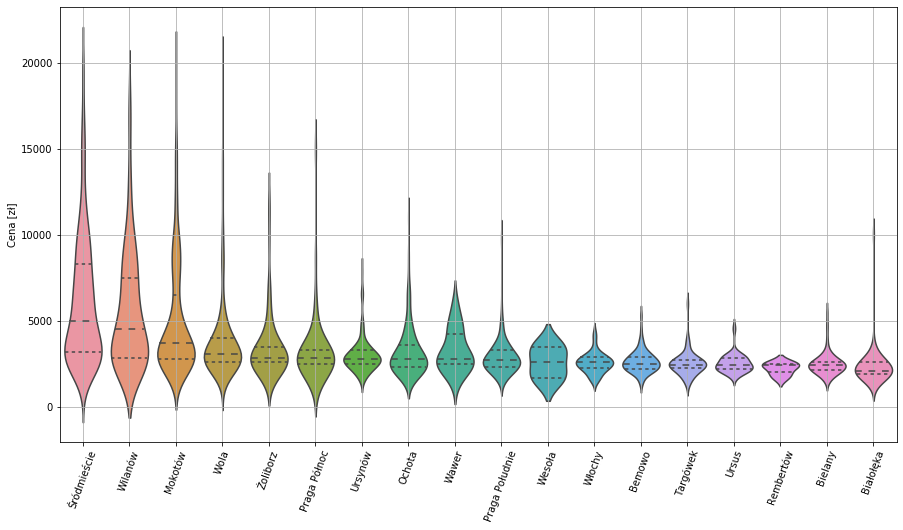

In [15]:
#df = apartaments[apartaments['Powierzchnia'] <= 60]
df = apartaments[apartaments['Cena rzeczywista'] <= 20000]

order = df.groupby('Nazwa dzielnicy')['Cena rzeczywista'].describe()['50%'].sort_values(ascending=False)

plt.figure(figsize=(15,8))
sns.violinplot(data=df, x='Nazwa dzielnicy', y='Cena rzeczywista', order=order.index, inner='quartile'
               , orient='v', scale='width')
plt.xticks(rotation=70)
plt.ylabel('Cena [zł]')
plt.xlabel('')
#plt.yticks(np.arange(0,21000,1000))
plt.grid()

*All violinplots are ordered by median price.*
## Comment:

All districts contain a lot of "`cheap`" apartaments with prices around `2000-3000 zł`. Addictionally, we notice that first 3 districts (`Śródmieście, Wilanów, Mokotów`) also contain comparable amount of more expensive apartaments, with prices around `8000 zł`. We distinct these two ranges by increased local tickness of violins.

## 3.2. Show median price for each district

In [16]:
plot_dict = apartaments.groupby('Numer dzielnicy')['Cena rzeczywista'].describe()['50%']
plot_dict.index = [str(i) for i in range(0,18)]

In [17]:
pd.DataFrame(apartaments.groupby('Nazwa dzielnicy')['Cena rzeczywista'].describe()['50%'].astype('int32').rename('Mediana cen [zł]').sort_values(ascending=False))

,Mediana cen [zł]
Nazwa dzielnicy,
Śródmieście,5300
Wilanów,4500
Mokotów,3700
Wola,3100
Żoliborz,2850
Praga Północ,2810
Ursynów,2800
Ochota,2800
Wawer,2775


In [18]:
# Create a base map
m_1 = folium.Map(location=[52.2323,21.0000], tiles='cartodbpositron', zoom_start=10)

# Add apartaments to the map
mc = MarkerCluster()
for idx, house in apartaments.iterrows():
    if notNan(house['φ']):
        mc.add_child(Marker([house['φ'], house['λ']], popup=str(house['Cena rzeczywista']) + "zł"))
m_1.add_child(mc)

# Add districts coloured by median price to the map
Choropleth(geo_data=geo.__geo_interface__, 
           data=plot_dict,
           key_on="feature.id", 
           fill_color='YlGnBu', 
           legend_name='Mediana cen [zł]',
          ).add_to(m_1)

# Display the map
embed_map(m_1, 'maps/m_1.html')

In [19]:
apartaments.head()

,Cena,Cena rzeczywista,Kaucja,Powierzchnia,Liczba pokoi,Rodzaj zabudowy,Piętro,Okna,Ogrzewanie,Stan wykończenia,...,λ,Czynsz - dodatkowo,Liczba pięter,Materiał budynku,Rok budowy,Odległość od najbliższej stacji metra,Najbliższa stacja metra,Odległość od centrum,Numer dzielnicy,Nazwa dzielnicy
0,2400,2400,2400.0,48.0,3,blok,2,plastikowe,miejskie,do zamieszkania,...,21.066343,NaN,NaN,NaN,NaN,2.3963,Metro Stadion Narodowy,4.5333,7.0,Praga Południe
1,2400,2900,3000.0,45.0,2,apartamentowiec,2,plastikowe,miejskie,do zamieszkania,...,20.930776,500.0,5.0,cegła,2014.0,0.2076,Metro Młociny,7.9005,5.0,Bielany
2,2600,2600,NaN,40.0,2,apartamentowiec,4,plastikowe,miejskie,do zamieszkania,...,21.044630,NaN,6.0,pustak,2018.0,2.1875,Metro Wierzbno,4.7630,6.0,Mokotów
3,2300,2700,2500.0,54.0,2,blok,1,plastikowe,miejskie,do zamieszkania,...,21.054128,400.0,5.0,NaN,2007.0,1.3607,Metro Trocka,7.2078,10.0,Targówek
4,2950,3300,NaN,54.0,3,blok,3,drewniane,miejskie,do zamieszkania,...,21.082662,350.0,4.0,cegła,2016.0,2.3051,Metro Natolin,10.4301,15.0,Wilanów


## 3.3. Correlate data

In [20]:
df = apartaments.copy().drop(columns=['φ', 'λ', 'Cena', 'Czynsz - dodatkowo', 'Kaucja', 'Numer dzielnicy'])

# Apply relevant conditions

#df = df[df['Odległość od centrum'] > 1]
#df = df[df['Odległość od centrum'] < 20]
df = df[df['Cena rzeczywista'] <= 20000]  # There is one `epic` outlier that has to be ommited
#df = df[df['Powierzchnia'] <= 100]
#df = df[df['Nazwa dzielnicy'] == 'Śródmieście']
#df = df[df['Okna'] == 'drewniane']

df = df[df['Liczba pokoi'] != "więcej niż 10"]
df['Liczba pokoi'] = df['Liczba pokoi'].astype('int32')

df.corr()

,Cena rzeczywista,Powierzchnia,Liczba pokoi,Liczba pięter,Rok budowy,Odległość od najbliższej stacji metra,Odległość od centrum
Cena rzeczywista,1.000000,0.818079,0.632374,0.046585,0.024196,-0.091954,-0.163318
Powierzchnia,0.818079,1.000000,0.823490,-0.014483,0.008889,-0.038562,-0.029744
Liczba pokoi,0.632374,0.823490,1.000000,-0.023774,0.017741,-0.012407,0.008859
Liczba pięter,0.046585,-0.014483,-0.023774,1.000000,0.050545,-0.018539,-0.036502
Rok budowy,0.024196,0.008889,0.017741,0.050545,1.000000,0.098413,0.180784
Odległość od najbliższej stacji metra,-0.091954,-0.038562,-0.012407,-0.018539,0.098413,1.000000,0.874735
Odległość od centrum,-0.163318,-0.029744,0.008859,-0.036502,0.180784,0.874735,1.000000


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]),
 <a list of 29 Text xticklabel objects>)

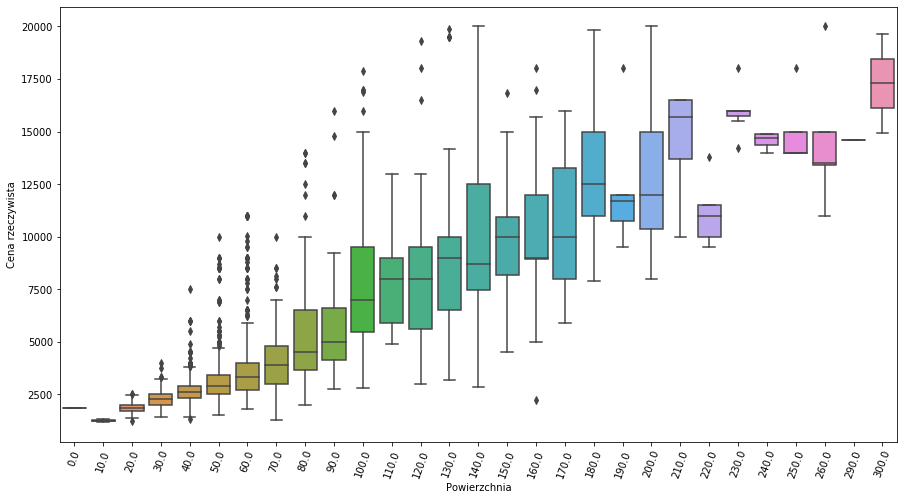

In [21]:
plt.figure(figsize=(15,8))
sns.boxplot('Powierzchnia', 'Cena rzeczywista', data=df.apply
           (lambda x: round(x/10)*10 if x.name == 'Powierzchnia' else x))
plt.xticks(rotation=70)
#plt.ylim(0, 7500)

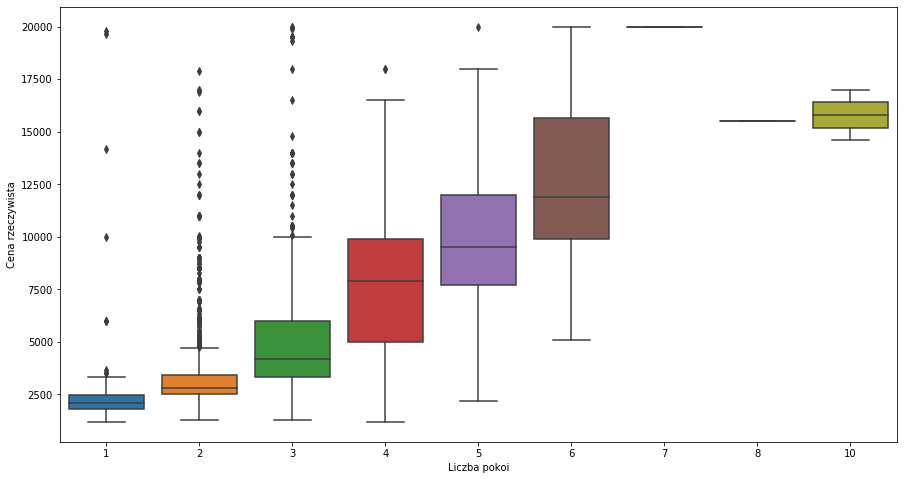

In [22]:
plt.figure(figsize=(15,8))
sns.boxplot('Liczba pokoi', 'Cena rzeczywista', data=df)
#plt.ylim(0, 5000)

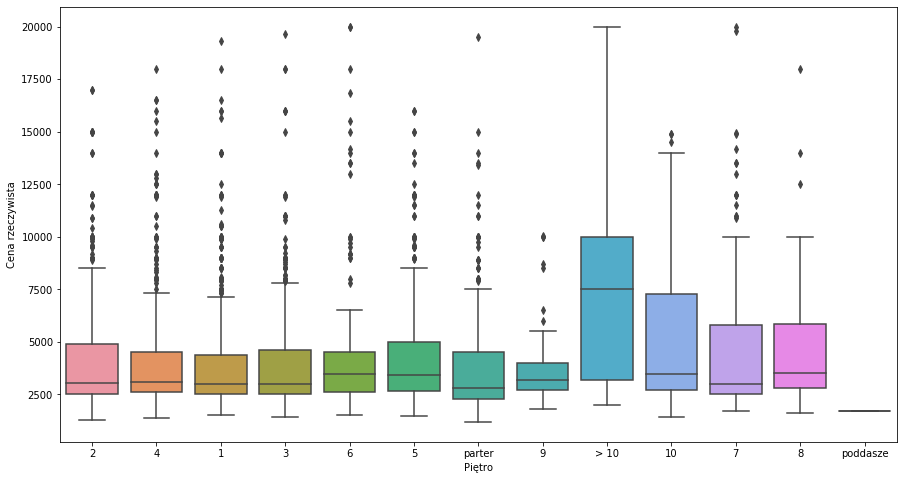

In [23]:
plt.figure(figsize=(15,8))
sns.boxplot('Piętro', 'Cena rzeczywista', data=df)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35]), <a list of 36 Text xticklabel objects>)

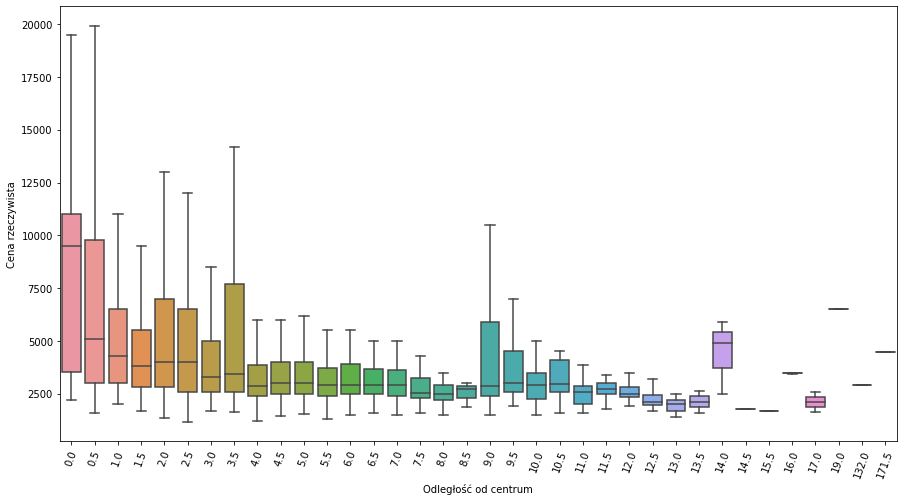

In [24]:
plt.figure(figsize=(15,8))
sns.boxplot('Odległość od centrum', 'Cena rzeczywista', data=df.apply
           (lambda x: round(x/0.5)*0.5 if x.name == 'Odległość od centrum' else x), showfliers=False)
plt.xticks(rotation=70)
#plt.ylim(1000, 5000)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]),
 <a list of 29 Text xticklabel objects>)

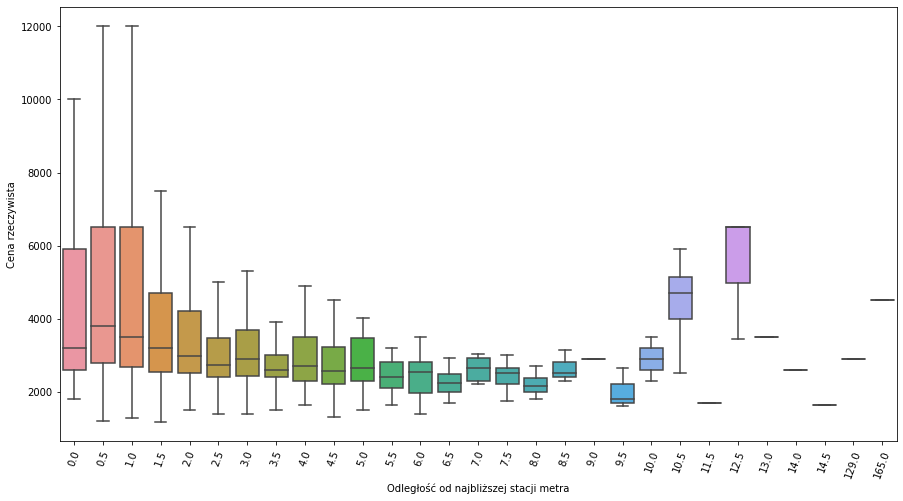

In [25]:
plt.figure(figsize=(15,8))
sns.boxplot('Odległość od najbliższej stacji metra', 'Cena rzeczywista', data=df.apply
           (lambda x: round(x/0.5)*0.5 if x.name == 'Odległość od najbliższej stacji metra' else x), showfliers=False)
plt.xticks(rotation=70)
#plt.ylim(1000, 7500)

Text(0, 0.5, 'Odległość od centrum [km]')

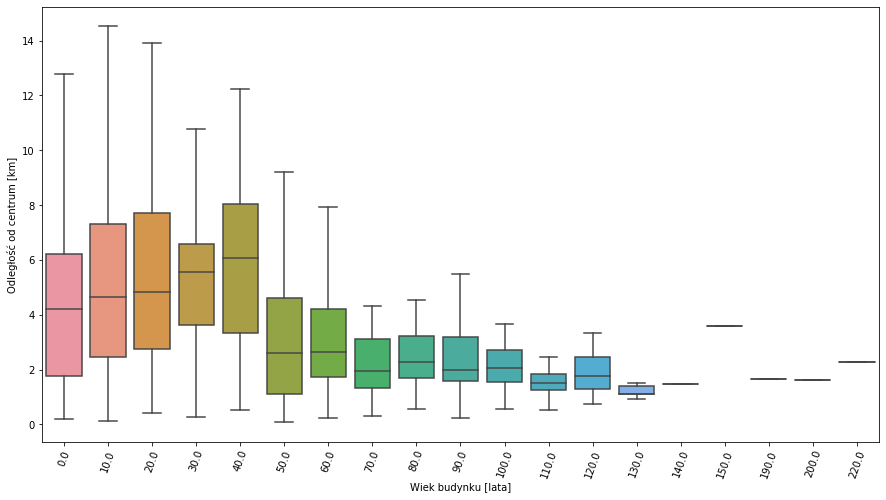

In [26]:
plt.figure(figsize=(15,8))
sns.boxplot('Rok budowy', 'Odległość od centrum', data=df.apply
           (lambda x: round((2019-x)/10)*10 if x.name == 'Rok budowy' else x), showfliers=False)
plt.xticks(rotation=70)
#plt.ylim(0,15)
plt.xlabel('Wiek budynku [lata]')
plt.ylabel('Odległość od centrum [km]')

Text(0, 0.5, 'Cena [zł]')

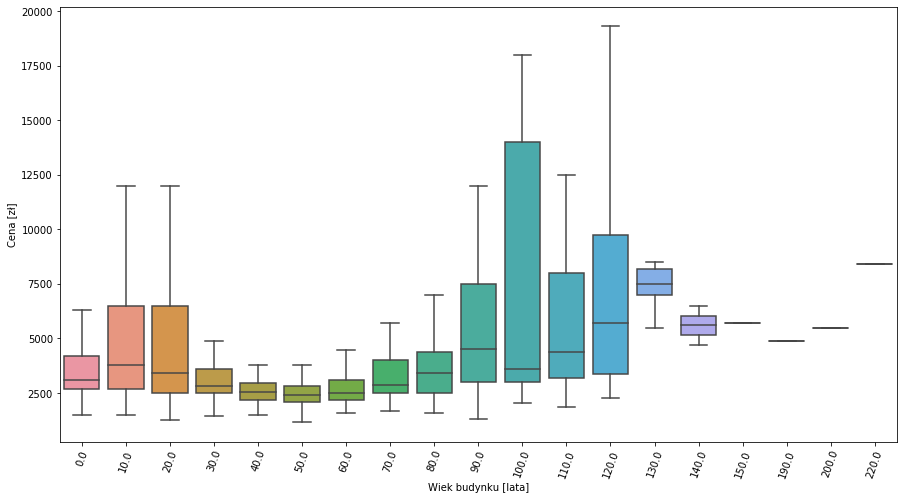

In [27]:
plt.figure(figsize=(15,8))
sns.boxplot('Rok budowy', 'Cena rzeczywista', data=df.apply
           (lambda x: round((2019-x)/10)*10 if x.name == 'Rok budowy' else x), showfliers=False)
plt.xticks(rotation=70)
#plt.ylim(0,15)
plt.xlabel('Wiek budynku [lata]')
plt.ylabel('Cena [zł]')

## Comments:
- `price` and `area of house` relation is `strongly linear`
- `price` and `number of rooms` relation is `strongly linear`
- there is `no relation` between `price` and `floor number`
- there is `some correlation` between `price` and `distance to city center`, aswell as between `nearest metro station location` and `price`. Noticably, there is a peak of price at a distance `~9 km` from city center. It's because exactly in `9 km` there is district `Wilanów`, which is a rich quarter of Warsaw and its prices are not connected with commutation. Peaks at `10.5 km` and `12.5 km` at `nearest metro station location` plot are caused by single houses at district `Wawer` and can be ignored.
- analysing `building's age` and `distance from city center` leads to conclusion, that Warsaw was destroyed in WWII and is being rebuilded starting from city center to `outside direction`
- from `price` vs `building's age` plot we see that the minimum price is for `age = 50 years` (buildings build at year 1970). New buldings aswell as very old buldings are `worth the most`.

# 3.4. Distribution of apartment's floor level

Text(0, 0.5, 'Ilość mieszkań')

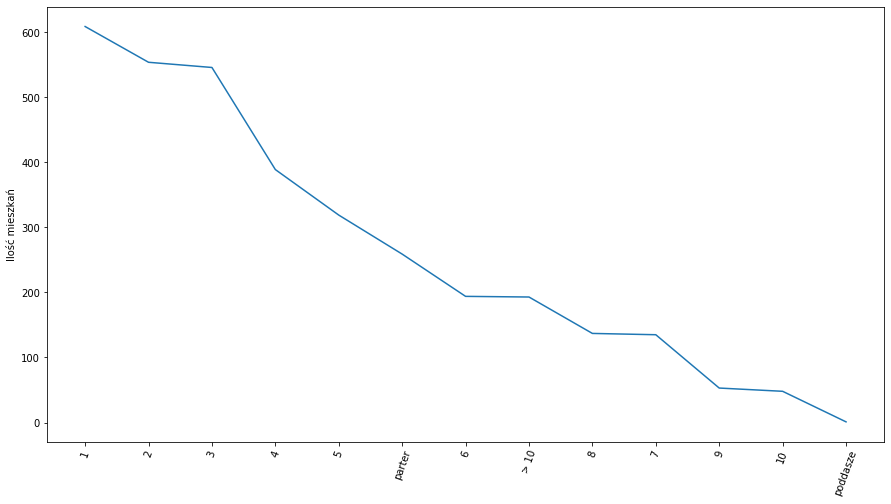

In [28]:
plt.figure(figsize=(15,8))
plt.plot(apartaments['Piętro'].value_counts())
plt.xticks(rotation=70)
plt.ylabel('Ilość mieszkań')

## Comment:
Most apartaments are suprisingly located not on the `groud floor` (parter), but rather on 1st, 2nd or 3rd floor.

# 4. Prediction

## 4.1. Linear regressor and support vector mashines
An approach to predict value of a property basing on its `area`, `number of rooms`, `year of build` and `location`.

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import r2_score

In [30]:
# Prepare input and target

df = apartaments.copy()
df = df[df['Cena rzeczywista'] <= 4000]  # Predict for prices below 4000 zł for more acc in this range
#df = df[df['Powierzchnia'] <= 100]


# Convert string values to integers
def Encode(df):
    for column in df.columns[df.columns.isin(['Okna', 'Nazwa dzielnicy'])]:
        df[column] = df[column].factorize()[0]
        
    # Convert number of rooms to integer type in all cases
    for column in ['Liczba pokoi']:
        for i in range(len(df[column])):
            if df[column].iloc[i] == 'parter':
                df[column].iloc[i] = 0
            elif df[column].iloc[i] == 'więcej niż 10' or df[column].iloc[i] == 'poddasze':
                df[column].iloc[i] = 10
            else:
                df[column].iloc[i] = int(df[column].iloc[i])
    return df
                                         

X = ['Powierzchnia', 'Liczba pokoi', 'φ', 'λ', 'Rok budowy']
Y = ['Cena rzeczywista']

df = df[X + Y].dropna()

x = Encode(df[X].copy())
y = df[Y]

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [31]:
# Split into equal lenght train and test sets

x_train, x_test, y_train, y_test = train_test_split( x, y, test_size=0.5, random_state = 324)
print(x_train.shape, x_test.shape)

(743, 5) (744, 5)


In [32]:
# Scale train and test set, basing only on train data

scaler_x = StandardScaler().fit(x_train)
x_train = scaler_x.transform(x_train)
x_test = scaler_x.transform(x_test)

In [33]:
# Choose and learn classifier

regressor = SVR(C=10000, gamma=0.1) 
#regressor = LinearRegression()
regressor.fit(x_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR(C=10000, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.1,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

Mean square error is 338.53716297107496
R^2 score is 0.669478977789534


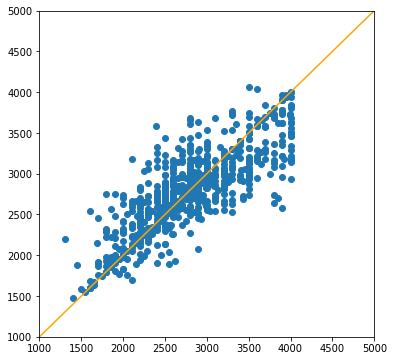

In [34]:
# Calculate error on train set

plt.figure(figsize=(6,6))
y_pred_train = regressor.predict(x_train)
plt.scatter(y_train, y_pred_train)

plt.xlim(1000, 5000)
plt.ylim(1000, 5000)
plt.plot([1000, 20000], [1000, 20000], color='orange')

mse = np.sqrt(mean_squared_error(y_true=y_train, y_pred=y_pred_train))
r2 = r2_score(y_train, y_pred_train)
print("Mean square error is {}\nR^2 score is {}".format(mse, r2))

Mean square error is 390.43276485276874
R^2 score is 0.5526583336837702


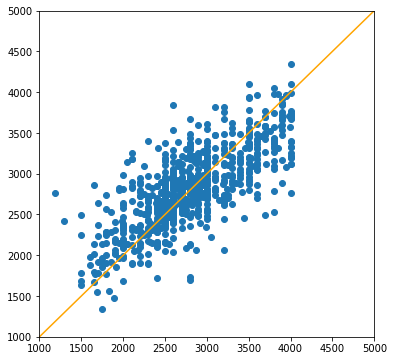

In [35]:
# Calculate error on test set

plt.figure(figsize=(6,6))
y_pred_test = regressor.predict(x_test)
plt.scatter(y_test, y_pred_test)

plt.xlim(1000, 5000)
plt.ylim(1000, 5000)
plt.plot([1000, 20000], [1000, 20000], color='orange')

mse = np.sqrt(mean_squared_error(y_true=y_test, y_pred=y_pred_test))
r2 = r2_score(y_test, y_pred_test)
print("Mean square error is {}\nR^2 score is {}".format(mse, r2))

## 4.2. Analyse of error in regression approach

,train error,test error
count,743.000000,744.000000
mean,1.471034,2.962941
std,12.679463,15.821172
min,-33.754642,-39.233453
25%,-5.547386,-6.586495
50%,-0.002504,1.094495
75%,7.198659,10.455857
max,68.963778,134.403877


Text(0.5, 0, 'relative error [%]')

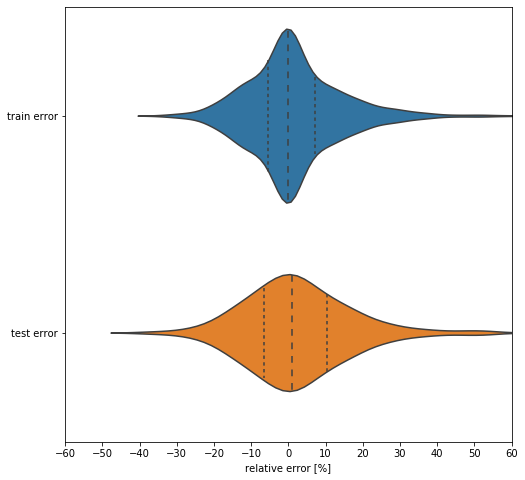

In [36]:
# For all predicted values measure relative difference from exact value and analyse its distribution

train_error = [100*(y_pred_train[i] - float(y_train.iloc[i])) / float(y_train.iloc[i]) for i in range(len(y_train))]
test_error = [100*(y_pred_test[i] - float(y_test.iloc[i])) / float(y_test.iloc[i]) for i in range(len(y_test))]

error_df = pd.DataFrame([train_error, test_error]).T.rename(columns={0:'train error', 1:'test error'})
display(error_df.describe())


plt.figure(figsize=(8,8))
sns.violinplot(data=error_df, inner='quartile', orient='h')
plt.xlim(-50,50)
plt.xticks(np.arange(-60, 65, 10))
plt.xlabel('relative error [%]')

## Comment:

`50% of data` in training set has relative error in range `(-5.5%, 7.2%)`, what means about `6% relative error` for half of the training set.

Similarly, `50% of data` in test set has relative error inside range `(-6.6%, 10.5%)`, which is `8.5% relative error` on average.

**For example:** if we have a sample `out of training set` of apartament that has price `2500 zł in advertisement`, this algorithm has `50% chance` to predict price in range `(2335 zł, 2765 zł)`.

## 4.3. Test on some hand-typed data

In [37]:
test = pd.DataFrame([[45, 2, 52.197751, 20.964537, 2018]], columns=['Powierzchnia', 'Liczba pokoi', 'φ', 'λ', 'Rok budowy'])
test_ = scaler_x.transform(test)
display(test)

print("For an apartment with area = {} m^2, {} room(s), build in {} and located at ({}, {}), predicted price is {} zł.".
      format(test['Powierzchnia'].iloc[0], test['Liczba pokoi'].iloc[0], test['Rok budowy'].iloc[0]
             , test['φ'].iloc[0], test['λ'].iloc[0], round(regressor.predict(test_)[0])))

,Powierzchnia,Liczba pokoi,φ,λ,Rok budowy
0,45,2,52.197751,20.964537,2018


For an apartment with area = 45 m^2, 2 room(s), build in 2018 and located at (52.197751, 20.964537), predicted price is 2913.0 zł.


## Comment:
True price for entered apartament is `3300 zł`, so the relative error is `-12%`.